# Task 1: Dimensionality Reduction
## Subtask 1: Data Loading and Data Preparation

In [1]:
from sklearn.datasets import fetch_lfw_people
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from sklearn.neural_network import MLPRegressor

#import the dataset and filter out the people with more than 30 pictures
data = fetch_lfw_people(min_faces_per_person=30, resize=0.5)
X_train, X_test, y_train, y_test = train_test_split(data.get("data"),data.get("target") , test_size=0.33, random_state=42)


In [2]:
print("How many different people are in the data? " + str(data.get("target_names").shape[0]))
print("How many images are in the data? " + str(data.get("data").shape[0]))
print("What is the size of the images? " + str(data.get("images")[0].shape))

How many different people are in the data? 34
How many images are in the data? 2370
What is the size of the images? (62, 47)


In [3]:
def find10DifFaces(X, y):
    imagesLabels = []
    imagesIndex = []
    i = 0
    #iterate thou data until ten different labels are found
    while len(imagesIndex) <10:
        if not y[i] in imagesLabels:
            imagesIndex.append(X[i])
            imagesLabels.append(y[i])
        i += 1
    return imagesIndex

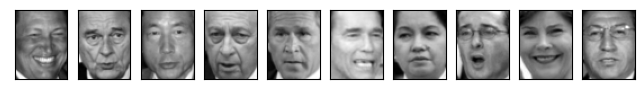

In [4]:
#plotting 10 different faces
bspImages = find10DifFaces(X_train, y_train)
fig, axes = plt.subplots(1,10, figsize=(8,8))    
for i,ax in enumerate(axes.flat):
    ax.imshow(bspImages[i].reshape( 62, 47), cmap=plt.cm.gray)      
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)

## Subtask 2: Dimensionality Reduction Using PCA

In [5]:
class PCA:
    
    def __init__(self):
        self.numberEigenvectors = None
        self.mean = None
        self.components = None
        self.eigValue = None
        self.eigVec = None
    
    #This function calculates the eigenvalues of the data matrix
    def fit(self, X):
        #define the mean of data points
        self.mean = np.mean(X, axis= 0)
        #center X
        X = X - self.mean
        # calc covariance Matx
        cov = np.cov(X.T)
        #calculate eigenvalues and eigenvectors
        eigValue, eigVec = np.linalg.eig(cov)
        
        #sort eigenvalues
        eigVec = eigVec.T
        idxs = np.argsort(eigValue)[::-1]
        self.eigValue = eigValue[idxs]
        self.eigVec = eigVec[idxs]
        
        #some parts of this class are related to (https://www.youtube.com/watch?v=52d7ha-GdV8)
    
    #This function is projecting an image onto a given number of eigenvalues and reconstructing
    #the image from the projection
    def reconstruct(self, X, numberEigenvectors):
        # right amount of EW
        V = self.eigVec[0:numberEigenvectors]  
        #PCA projections ("scores")
        Z = np.dot(X.T, V.T)    
        #reconstructing the i,age (X^=ZV.⊤=XVV.⊤ + mean)
        return np.dot(Z.reshape(1,-1) , V) + self.mean    
    
    # This function simply returns a given amount of principal components
    def getPrinzipalComponents(self, number):   
        return self.eigVec[0:number]


In [6]:
#reconstructing and plotting pictures
def reconstrucktPlotPictures(pca, numberEw):
    fig, axes = plt.subplots(1,10, figsize=(8,8))    
    for i,ax in enumerate(axes.flat):
        ax.imshow(pca.reconstruct(bspImages[i], numberEw).reshape( 62, 47).real, cmap=plt.cm.gray)      
        ax.get_yaxis().set_visible(False)
        ax.get_xaxis().set_visible(False)
        ax.set_title("d= "+str(numberEw))
    plt.show
    

reference pictures: 


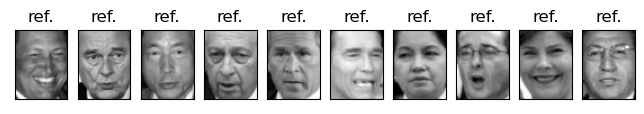

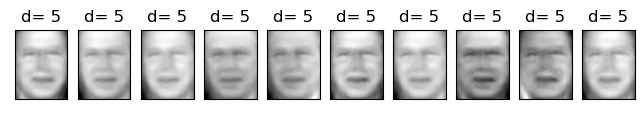

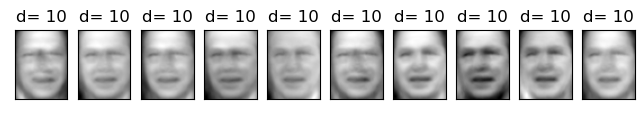

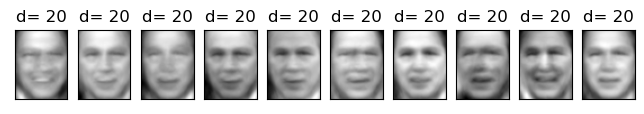

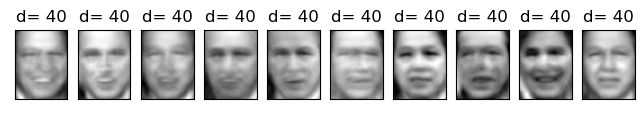

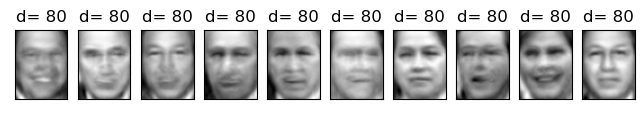

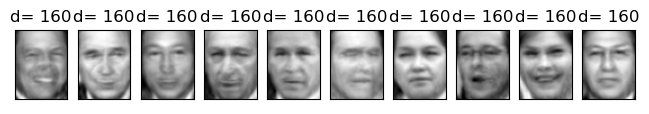

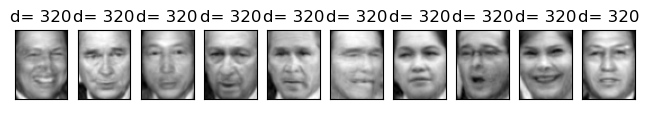

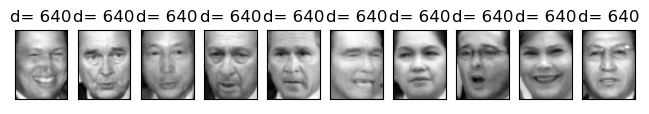

In [7]:
print("reference pictures: ")
#get different example faces
bspImages = find10DifFaces(X_train, y_train)
#plot reference faces
fig, axes = plt.subplots(1,10, figsize=(8,8))    
for i,ax in enumerate(axes.flat):
    ax.imshow(bspImages[i].reshape( 62, 47), cmap=plt.cm.gray)      
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.set_title("ref.")
    
#calculate eigenvectors only once to save runtime
pca = PCA()
pca.fit(X_train) 
#number of ew from task
d = [5, 10, 20, 40, 80, 160, 320, 640] 
#plot reconstructed images
for i in d:
    reconstrucktPlotPictures(pca, i)

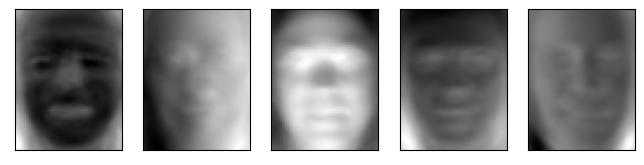

In [8]:
eigenVec = pca.getPrinzipalComponents(5)
#ploting first 5 prinzipell components
fig, axes = plt.subplots(1,5, figsize=(8,8))    
for i,ax in enumerate(axes.flat):
    ax.imshow(eigenVec[i].reshape( 62, 47).real, cmap=plt.cm.gray)      
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)

In [9]:
#looping reconstruction over every image

def reconstructAllImages(pca, X, numberEw):
    res = []
    for i in range(X.shape[0]):
        res.append(pca.reconstruct(X[i], numberEw).reshape(-1,).real)
    return np.asarray(res)

#training LRC on the reconstructed dataset
def logicRegressionClassifer(numberOfEw, X_train, y_train, X_test, y_test):
    #reconstruct data from the given number of eigenvectors
    reconstructedX = reconstructAllImages(pca, X_train, numberOfEw)
    #scale reconstructed data
    scaler = MinMaxScaler()
    scaler.fit(X_train, y_train)
    reconstructedX = scaler.transform(reconstructedX)
    #train LRC
    clf = LogisticRegression(random_state=42, max_iter=300).fit(reconstructedX, y_train)
    print("(d="+str(i)+") Accuracy  on training dataset: " + str(clf.score(scaler.transform(X_train), y_train)))
    print("(d="+str(i)+") Accuracy  on testing dataset: " + str(clf.score(scaler.transform(X_test), y_test)))
    

In [10]:
# logistic regression classifer

#prject all pictures to eigenvectors:
d = [5, 10, 20, 40, 80, 160, 320, 640]  #number of eigenvectors from task
for i in (d):
    logicRegressionClassifer(i, X_train, y_train, X_test, y_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(d=5) Accuracy  on training dataset: 0.029615626969124134
(d=5) Accuracy  on testing dataset: 0.02681992337164751


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(d=10) Accuracy  on training dataset: 0.0976685570258349
(d=10) Accuracy  on testing dataset: 0.07279693486590039


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(d=20) Accuracy  on training dataset: 0.36546943919344677
(d=20) Accuracy  on testing dataset: 0.3205619412515964


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(d=40) Accuracy  on training dataset: 0.6099558916194077
(d=40) Accuracy  on testing dataset: 0.44189016602809705


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(d=80) Accuracy  on training dataset: 0.8040327662255828
(d=80) Accuracy  on testing dataset: 0.565772669220945


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(d=160) Accuracy  on training dataset: 0.8922495274102079
(d=160) Accuracy  on testing dataset: 0.6309067688378033


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(d=320) Accuracy  on training dataset: 0.9395085066162571
(d=320) Accuracy  on testing dataset: 0.6462324393358876
(d=640) Accuracy  on training dataset: 0.947069943289225
(d=640) Accuracy  on testing dataset: 0.6334610472541508


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [11]:
#reference classifiyer on original Data
scaler = MinMaxScaler()
scaler.fit(X_train, y_train)
scaledX = scaler.transform(X_train)
clf = LogisticRegression(random_state=42, max_iter=300).fit(scaledX, y_train)
print("Reference accuracy  on training dataset: " + str(clf.score(scaler.transform(X_train), y_train)))
print("Reference accuracy on testing dataset: " + str(clf.score(scaler.transform(X_test), y_test)))

Reference accuracy  on training dataset: 1.0
Reference accuracy on testing dataset: 0.7088122605363985


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Subtask 3: Dimensionality Reduction Using Autoencoders

In [12]:
#functions from task
def encode(X, mlp):
    """
    This function is not working for general MLPs,
    the MLP must have the layer-configuration as
    stated in the exercise description.

    X must have the shape
    n_images x (width in pixels * height in pixels)
    """
    z = X
    for i in range(len(mlp.coefs_) // 2):
        z = z @ mlp.coefs_[i] + mlp.intercepts_[i]
        z = np.maximum(z, 0)
    return z

def decode(Z, mlp):
    """
    This function is not working for general MLPs, the MLP
    must have the layer-configuration as stated in the
    exercise description.

    Z must have the shape n_images x d
    """
    z = Z
    for i in range(len(mlp.coefs_) // 2, len(mlp.coefs_)):
        z = z @ mlp.coefs_[i] + mlp.intercepts_[i]
        if i < len(mlp.coefs_) - 1:
            z = np.maximum(z, 0)
    return z

In [13]:
#define hidden layers
a = 500
b = 100
d = [40,80]

reconstructedFaces = []
X = np.asarray(X_train)

#looping over d = {40, 80}
for i in [d[0], d[1]]:
    #training MLP regressor on dataset with different layer sizes
    mlp = MLPRegressor(hidden_layer_sizes=(a, b, i, b, a),
                           random_state=42, max_iter=500,alpha=1e-15, activation = "relu").fit(np.asarray(X_train), np.asarray(X_train))
    #encoting and decoding data
    encoded = encode(X, mlp)
    decoded = decode(encoded, mlp)
    reconstructedFaces.append(decoded)
    
    


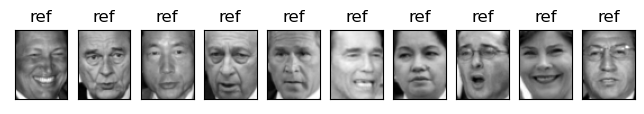

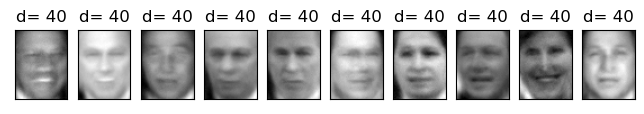

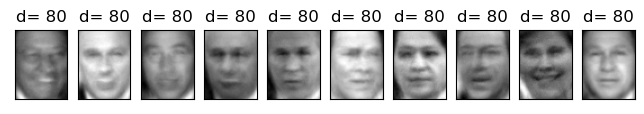

In [14]:
#reference images
bspImages = find10DifFaces(X_train, y_train)
fig, axes = plt.subplots(1,10, figsize=(8,8))    #ploting
for i,ax in enumerate(axes.flat):
    ax.imshow(bspImages[i].reshape( 62, 47), cmap=plt.cm.gray)      
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.set_title("ref")
bspImages = find10DifFaces(decoded, y_train)   

#reconstructed images
for index, i in enumerate(reconstructedFaces):
    bspImages = find10DifFaces(i, y_train)
    fig, axes = plt.subplots(1,10, figsize=(8,8))    #ploting
    for i,ax in enumerate(axes.flat):
        ax.imshow(bspImages[i].reshape( 62, 47), cmap=plt.cm.gray)      
        ax.get_yaxis().set_visible(False)
        ax.get_xaxis().set_visible(False)
        ax.set_title("d= "+str(d[index]))

In [15]:
#training an LRC on the reconstructed images
for dIndex, i  in enumerate(reconstructedFaces):
    scaler = MinMaxScaler()
    scaler.fit(i, y_train)
    X_train_transformed = scaler.transform(i)
    clf = LogisticRegression(random_state=42, max_iter=500).fit(X_train_transformed, y_train)
    print("(d="+str(d[dIndex])+") Accuracy on training dataset: " + str(clf.score(scaler.transform(X_train), y_train)))
    print("(d="+str(d[dIndex])+") Accuracy on testng dataset: " + str(clf.score(scaler.transform(X_test), y_test)))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(d=40) Accuracy on training dataset: 0.6357908002520479
(d=40) Accuracy on testng dataset: 0.5006385696040868
(d=80) Accuracy on training dataset: 0.796471329552615
(d=80) Accuracy on testng dataset: 0.6091954022988506


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
